In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.pipeline import make_pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Importing the Dependencies

Data Collection & Pre-Processing

In [2]:
# loading the data from csv file to a pandas Dataframe
raw_mail_data = pd.read_csv('./mail_data.csv', encoding='latin1')

In [3]:
print(raw_mail_data)

     Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham              Will Ã¼ b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [4]:
# replace the null values with a null string
mail_data = raw_mail_data.where((pd.notnull(raw_mail_data)),'')

In [5]:
# printing the first 5 rows of the dataframe
mail_data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# checking the number of rows and columns in the dataframe
mail_data.shape

(5572, 2)

Label Encoding

In [7]:
# Encode labels
label_encoder = LabelEncoder()
mail_data['Category'] = label_encoder.fit_transform(mail_data['Category'])  # ham = 0, spam = 1

spam  -  0

ham  -  1

In [8]:
# separating the data as texts and label

X = mail_data['Message']

y = mail_data['Category']

In [53]:
print(X)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ã¼ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object


In [54]:
print(y)

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: Category, Length: 5572, dtype: int64


Splitting the data into training data & test data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=33)

In [14]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(5572,)
(4457,)
(1115,)


Feature Extraction

In [15]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Save vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [16]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=33),
    'Support Vector Classifier': SVC(probability=True, kernel='linear', random_state=33)
}

results = {}

In [17]:
# Train, cross-validate and evaluate models
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = None
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_tfidf)[:, 1]
    else:
        y_scores = model.decision_function(X_test_tfidf)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Cross-validation
    pipeline = make_pipeline(TfidfVectorizer(stop_words='english', lowercase=True), model)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

    results[name] = {
        'Model': model,
        'Accuracy': acc,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'Confusion Matrix': cm,
        'ROC AUC': roc_auc,
        'CV Accuracy Mean': cv_scores.mean(),
        'FPR': fpr,
        'TPR': tpr
    }

In [18]:
# Save models
for name, data in results.items():
    joblib.dump(data['Model'], f"{name.replace(' ', '_').lower()}_model.pkl")

In [19]:
# Display evaluation results
eval_df = pd.DataFrame({k: {
    'Accuracy': v['Accuracy'],
    'Precision': v['Precision'],
    'Recall': v['Recall'],
    'F1-Score': v['F1-Score'],
    'ROC AUC': v['ROC AUC'],
    'CV Accuracy Mean': v['CV Accuracy Mean']
} for k, v in results.items()}).T

print("Model Evaluation Comparison:")
print(eval_df)

Model Evaluation Comparison:
                           Accuracy  Precision    Recall  F1-Score   ROC AUC  \
Logistic Regression        0.967713   0.991304  0.765101  0.863636  0.989474   
Naive Bayes                0.975785   0.991935  0.825503  0.901099  0.985980   
Random Forest              0.977578   0.992063  0.838926  0.909091  0.988512   
Support Vector Classifier  0.985650   0.985401  0.906040  0.944056  0.990937   

                           CV Accuracy Mean  
Logistic Regression                0.964106  
Naive Bayes                        0.968054  
Random Forest                      0.974513  
Support Vector Classifier          0.982591  


<Figure size 1000x600 with 0 Axes>

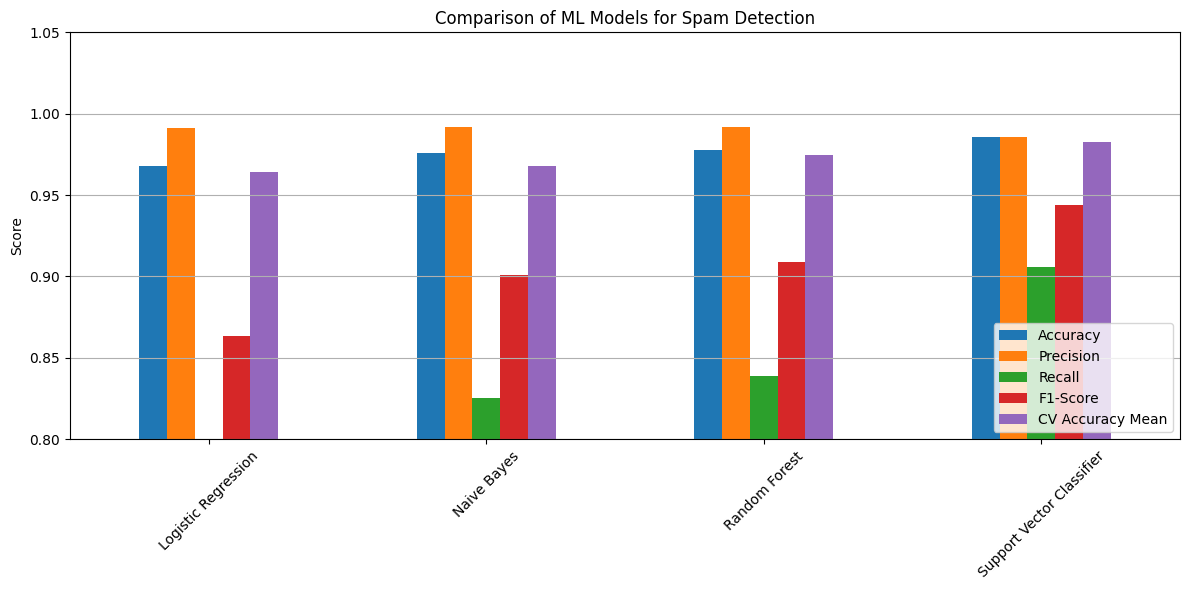

In [20]:
# Plot comparison
plt.figure(figsize=(10, 6))
eval_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Accuracy Mean']].plot(kind='bar', figsize=(12, 6))
plt.title("Comparison of ML Models for Spam Detection")
plt.ylabel("Score")
plt.ylim(0.8, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

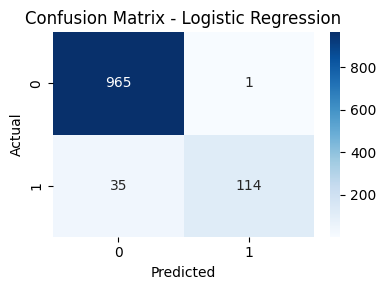

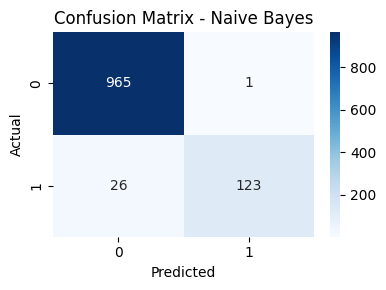

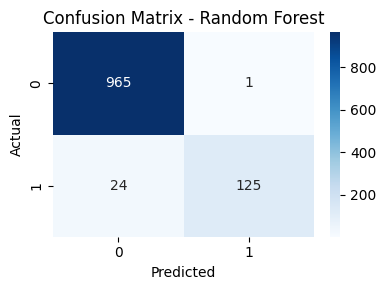

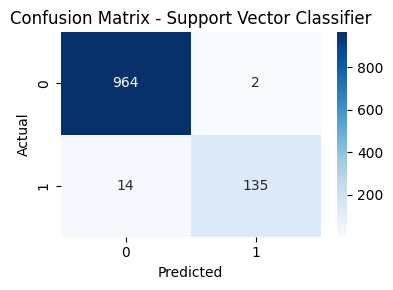

In [21]:
# Show confusion matrices
for name, metrics in results.items():
    plt.figure(figsize=(4, 3))
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

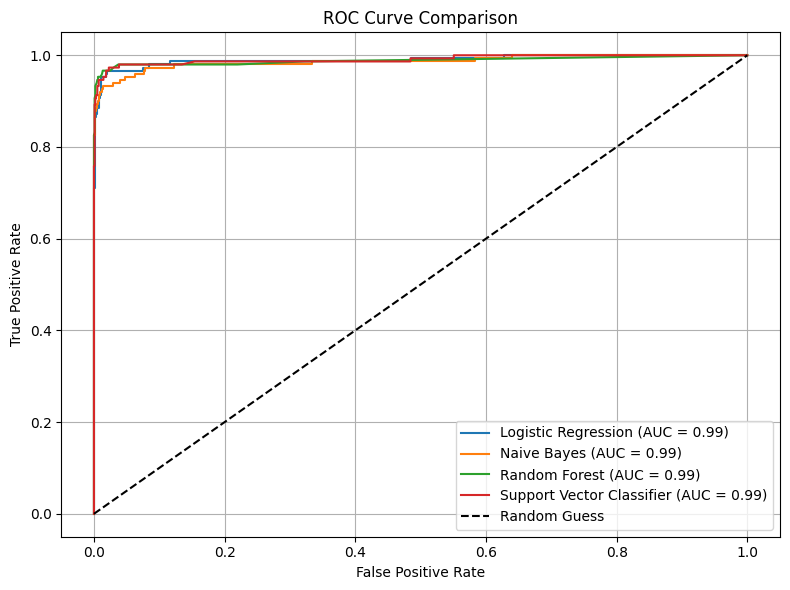

In [22]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))
for name, metrics in results.items():
    plt.plot(metrics['FPR'], metrics['TPR'], label=f"{name} (AUC = {metrics['ROC AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Support for real-time prediction
def predict_email_category(model_path, vectorizer_path, new_message):
    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)
    new_vector = vectorizer.transform([new_message])
    prediction = model.predict(new_vector)
    category = "Spam" if prediction[0] == 1 else "Ham"
    return category

# Example usage
example_text = "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/123456 to claim now."
predicted_label = predict_email_category("logistic_regression_model.pkl", "tfidf_vectorizer.pkl", example_text)
print(f"Predicted label: {predicted_label}")

Predicted label: Spam
